<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/01-Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing JaxPM
!pip install --quiet --upgrade jax
!pip install --quiet jaxpm

In [1]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn

In [2]:
mesh_shape = [128, 128, 128]
box_size = [128., 128., 128.]
snapshots = jnp.array([0.1, 0.5, 1.0])

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions and particles
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    # Initial displacement
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)

    # Return the simulation volume at requested timesteps
    return initial_conditions ,  particles + dx , res[0]

In [3]:
initial_conditions , lpt_particles , ode_particles = run_simulation(0.25, 0.8)

/home/wassim/micromamba/envs/jax/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


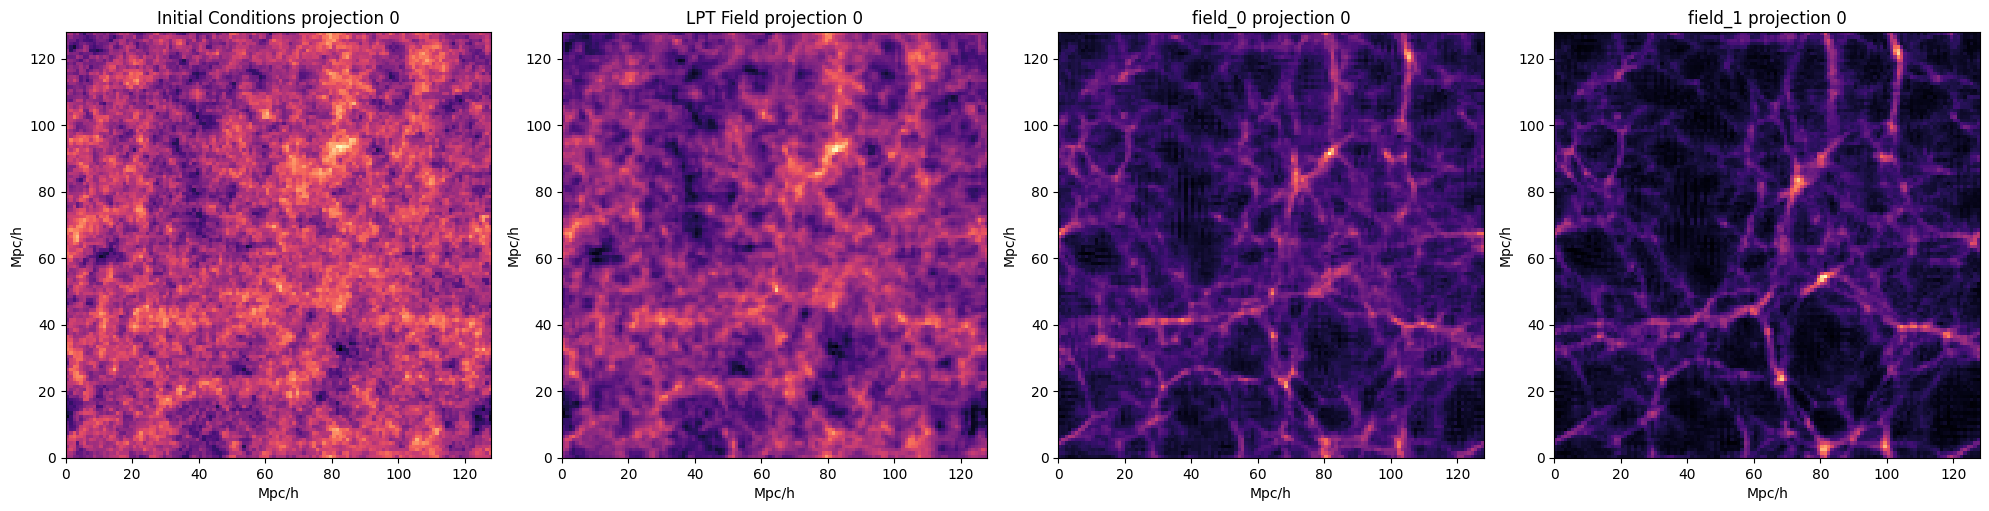

In [4]:
from jaxpm.plotting import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : jnp.log10(cic_paint(jnp.zeros(mesh_shape) ,lpt_particles) + 1)}
for i , field in enumerate(ode_particles[1:]):
    fields[f"field_{i}"] = jnp.log10(cic_paint(jnp.zeros(mesh_shape) , field)+1)
plot_fields_single_projection(fields)